**YOUR NAME**

Spring 2022

CS 251: Data Analysis and Visualization

# Lab 7: Visualizing Radial Basis Function Networks

In [21]:
import numpy as np
import scipy.linalg as spla
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

from scipy.spatial import distance
import scipy.linalg



## Task 1: Load dataset and Initialize variables

### 1a) Import Data
- Below, using numpy [load](https://numpy.org/doc/stable/reference/generated/numpy.load.html) load in the sample data (`train_samples.npy`) and labels (`train_labels.npy`). the training set has 5000 samples.

In [22]:
train_samples = np.load('data/train_samples.npy')
train_labels = np.load('data/train_labels.npy')

print(train_samples.shape)
print(train_samples)
print(train_labels.shape)
print(train_labels)

(5000, 4)
[[0.68030754 0.45049925 0.31969246 0.54950075]
 [0.09767211 0.68423303 0.90232789 0.31576697]
 [0.75536141 0.42515587 0.24463859 0.57484413]
 ...
 [0.62717587 0.86755419 0.37282413 0.13244581]
 [0.22935081 0.24469244 0.77064919 0.75530756]
 [0.76907972 0.58833893 0.23092028 0.41166107]]
(5000,)
[2 1 2 ... 1 0 2]


### 1b) Create Clusters

1. The number of nodes in the hidden layer will be 27.
2. Because the dataset has 3 classes, the number of output units will be 3.  
3. Create an instance of the [KMeans clustering algorithm class](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), with the number of clusters as the number of nodes in the hidden layer.
    1. Calculate the `cluster_assignments` by fitting the KMeans clustering algorithm to the samples (train_samples) with the classes (train_labels), and predicting which clusters each sample would be assigned to.
    2. Assign the cluster centroids to the variable `prototypes`.  
4. Calcuate the `sigmas` for each cluster, the sigma is the mean distance between the points assigned to a prototype and the prototype.
    1. The shape of sigmas should be an array with the length of the number of hidden nodes.
    2. In the lab you can use [cdist](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html) to compute distance between the centroid and the datapoints assigned to it.  `cdist` expects two 2D arrays, so you will need to make your prototype a 2D array.

In [23]:
import timeit
import analysis as an
import cupy as cp
import knn as kn
np.random.seed(10)

num_hidden_nodes = 1000

KCLuster = KMeans(n_clusters=num_hidden_nodes)
print(train_labels)
print(train_samples)
print(train_samples.shape)
print(train_samples[:, :2])
cluster_assignments = KCLuster.fit_predict(train_samples[:, :2])
prototypes = KCLuster.cluster_centers_

print(prototypes)
print(prototypes.shape)

def sigma1(prototypes, cluster_assignments, train_samples):
    sigmas = np.zeros(prototypes.shape[0])
    for i in range(prototypes.shape[0]):
        sigmas[i] = np.mean(distance.cdist(prototypes[i].reshape(1,-1), train_samples[cluster_assignments == i, :2], 'euclidean'))
    return sigmas

def sigma2(prototypes, cluster_assignments, train_samples):
    sigmas = np.zeros(prototypes.shape[0])
    for i in range(prototypes.shape[0]):
        sigmas[i] = np.mean(an.Analysis.lp_norm_v2_pList(prototypes[i].reshape(1,2), train_samples[cluster_assignments == i, :2], 2)[0])
    return sigmas

def sigma3(prototypes, cluster_assignments, train_samples):
    sigmas = np.zeros(prototypes.shape[0])
    for i in range(prototypes.shape[0]):
        sigmas[i] = np.mean(kn.d_pt_to_pts(prototypes[i].reshape(2), train_samples[cluster_assignments == i, :2], an.Analysis.l2_norm))
    return sigmas

time1 = timeit.timeit(lambda: sigma1(prototypes, cluster_assignments, train_samples), number=100)
time2 = timeit.timeit(lambda: sigma2(prototypes, cluster_assignments, train_samples), number=100)
time3 = timeit.timeit(lambda: sigma3(prototypes, cluster_assignments, train_samples), number=100)

print(f"Time1: {time1}")
print(f"Time2: {time2}")
print(f"Time3: {time3}")

sigma1_ = sigma1(prototypes, cluster_assignments, train_samples)
sigma2_ = sigma2(prototypes, cluster_assignments, train_samples)
sigma3_ = sigma3(prototypes, cluster_assignments, train_samples)

print(f"Sigma 1 == Sigma 2 {np.allclose(sigma1_, sigma2_, atol=1e-5)}") 
print(f"Sigma 1 == Sigma 3 {np.allclose(sigma1_, sigma3_, atol=1e-5)}")
print(f"Sigma 2 == Sigma 3 {np.allclose(sigma2_, sigma3_, atol=1e-5)}")

print(f"Sigma1: {sigma1_}")
print(f"Sigma2: {sigma2_}")
print(f"Sigma3: {sigma3_}")
if time1 < time2:
    sigmas = sigma1(prototypes, cluster_assignments, train_samples)
else:
    sigmas = sigma2(prototypes, cluster_assignments, train_samples)
print(f"Sigmas: {sigmas}")




[2 1 2 ... 1 0 2]
[[0.68030754 0.45049925 0.31969246 0.54950075]
 [0.09767211 0.68423303 0.90232789 0.31576697]
 [0.75536141 0.42515587 0.24463859 0.57484413]
 ...
 [0.62717587 0.86755419 0.37282413 0.13244581]
 [0.22935081 0.24469244 0.77064919 0.75530756]
 [0.76907972 0.58833893 0.23092028 0.41166107]]
(5000, 4)
[[0.68030754 0.45049925]
 [0.09767211 0.68423303]
 [0.75536141 0.42515587]
 ...
 [0.62717587 0.86755419]
 [0.22935081 0.24469244]
 [0.76907972 0.58833893]]
[[0.91722428 0.45832247]
 [0.38158583 0.4971121 ]
 [0.62105271 0.60106871]
 ...
 [0.45313235 0.8300373 ]
 [0.83775613 0.68232347]
 [0.61662155 0.06958888]]
(1000, 2)
Time1: 1.8909954999980982
Time2: 2.5916465999907814
Time3: 3.1350260000035632
Sigma 1 == Sigma 2 True
Sigma 1 == Sigma 3 True
Sigma 2 == Sigma 3 True
Sigma1: [0.00914231 0.00671441 0.00479734 0.00925358 0.00529283 0.01100265
 0.00892661 0.0083674  0.00871009 0.00731468 0.00514659 0.00896341
 0.00183486 0.00651737 0.0086584  0.00547905 0.00302753 0.00538319
 0.

### 1c) Visualize Clusters

1. Create a scatterplot of the training data with the x coordinates, y coordinates, coloring the points using the class
2. On the same plot as the scatterplot. Draw the clusters
    1. For each cluster, draw a [circle](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Circle.html) with the center at the prototype coordinates, using the sigma as the radius.  
    2. Add the circle to the axis. [add_patch](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.add_patch.html)
    3. Set the alpha of the circles to be partially transparent and the facecolor and edgecolor to something easily differentiated from the data.
3. Title the plot.

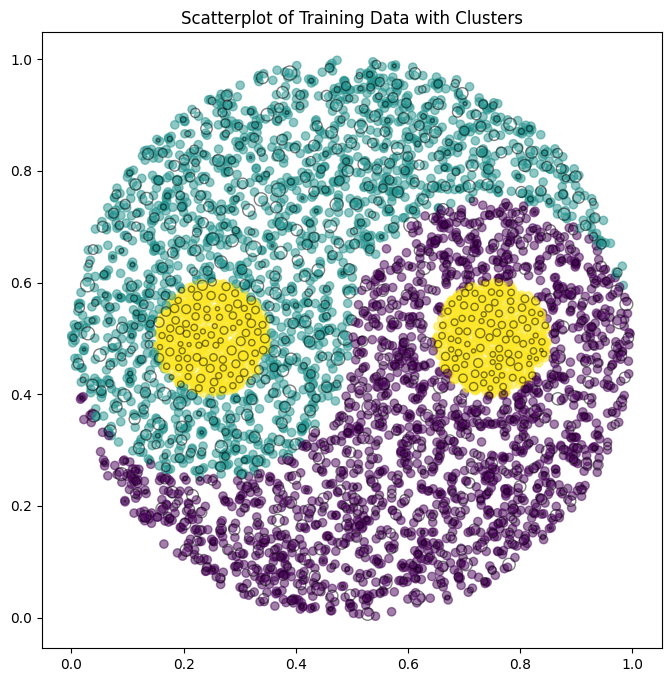

In [24]:
# Scatterplot of the training data
plt.figure(figsize=(8,8))

plt.scatter(train_samples[:,0], train_samples[:,1], c=train_labels, cmap='viridis', alpha=0.5)

# Draw the clusters
for i in range(num_hidden_nodes):
    circle = plt.Circle(prototypes[i], sigmas[i], alpha=0.5, facecolor='none', edgecolor='black')
    plt.gca().add_patch(circle)
    
plt.title('Scatterplot of Training Data with Clusters')

plt.show()


### 2c) Visualize Model

1. Create a scatterplot of the training data with the x coordinates, y coordinates, coloring the points using the class
2. On the same plot as the scatterplot. Draw the circles to represent the clusters and color them based on the resulting weights given below.
    1. For each cluster, draw a circle with the center at the prototype coordinates, using the sigma as the radius. 
    2. Set the alpha of the circles to be semi-transparent
    3. Using the weights, determine whether that node represents the first class or the second.  Color the classes different facecolors with a black edgecolor.
3. Title the plot.

Heat mat shape: (1000, 1001)
Heat mat: [[1.00000000e+000 0.00000000e+000 0.00000000e+000 ... 2.47033801e-243
  0.00000000e+000 1.00000000e+000]
 [0.00000000e+000 1.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 1.00000000e+000]
 [1.53519385e-281 0.00000000e+000 1.00000000e+000 ... 9.35900147e-231
  0.00000000e+000 1.00000000e+000]
 ...
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 1.00000000e+000]
 [1.74729966e-147 0.00000000e+000 0.00000000e+000 ... 1.00000000e+000
  0.00000000e+000 1.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  1.00000000e+000 1.00000000e+000]]
Mega Heat mat shape: (5000, 1001)
Mega Heat mat: [[1.05689235e-146 0.00000000e+000 1.04143927e-247 ... 0.00000000e+000
  0.00000000e+000 1.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 ... 0.00000000e+000
  0.00000000e+000 1.00000000e+000]
 [1.20031056e-071 0.00000000e+000 0.00000000e+000 ... 6.64588036e-

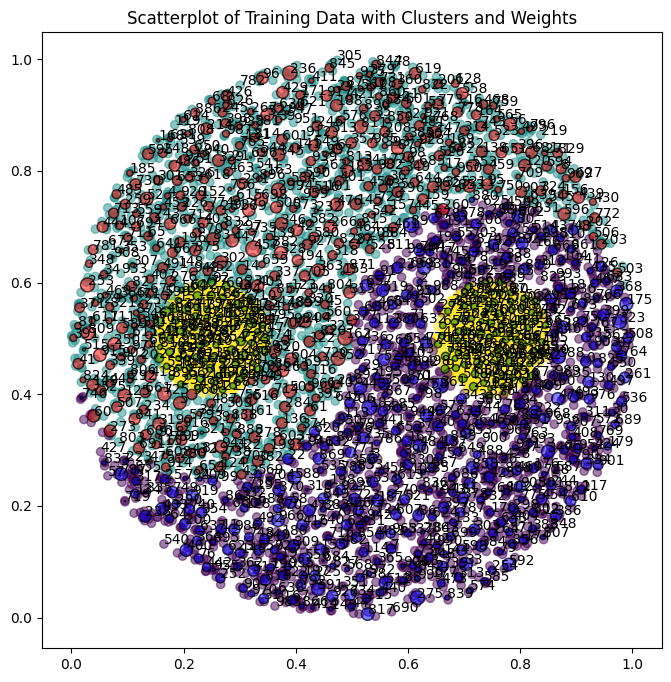

In [25]:
"""wts = [[ -0.5570424048800952 , 0.3202160585838569 , 0.23682634629623894 ],
[ -0.3171422177115015 , -0.5409465973983156 , 0.8580888151098163 ],
[ 0.6501785675835832 , -0.6140910366378967 , -0.03608753094568832 ],
[ 0.7207473857343744 , -0.6496895118638342 , -0.07105787387053947 ],
[ -0.550871219456205 , 0.5872852054600008 , -0.03641398600379539 ],
[ 0.3532083661950579 , -0.3184038242354737 , -0.03480454195958436 ],
[ 0.5899355040821072 , -0.5743852205393468 , -0.01555028354276178 ],
[ 0.6241629352784015 , -0.7388128108028282 , 0.11464987552442561 ],
[ -0.5322569306148579 , -0.35471462965224054 , 0.886971560267099 ],
[ 0.730718441746891 , -0.6906107736473123 , -0.04010766809957797 ],
[ -0.7550411413571223 , 0.7805198647746734 , -0.025478723417550884 ],
[ -0.6248305033008243 , 0.6931638233004551 , -0.06833331999963012 ],
[ -0.5553261848258912 , -0.44640157348044474 , 1.0017277583063364 ],
[ 0.7930156552508725 , -0.7578950605081061 , -0.03512059474276535 ],
[ -0.18428436965187162 , 0.26802738764012257 , -0.08374301798825065 ],
[ -0.5821044078783354 , 0.7101334403163303 , -0.12802903243799407 ],
[ 0.20359206915010294 , -0.11769817258500735 , -0.08589389656509583 ],
[ -0.014715157691860672 , 0.08139776227155551 , -0.06668260457969426 ],
[ -0.6544859843109327 , 0.6634576887722878 , -0.008971704461356379 ],
[ -0.45232271841183813 , -0.5675279539890884 , 1.0198506724009277 ],
[ -0.39356348955524195 , -0.687363406967407 , 1.0809268965226482 ],
[ 0.7847005643967092 , -0.6707702042343202 , -0.11393036016239 ],
[ -0.6498059530388826 , -0.39718222703802164 , 1.0469881800769036 ],
[ -0.5761006902467009 , 0.5936842147082291 , -0.017583524461527965 ],
[ -0.4488142326141757 , 0.479831856918763 , -0.0310176243045874 ],
[ -0.5627138135343364 , 0.644409090041507 , -0.08169527650716928 ],
[ 0.6179733599227316 , -0.6014047208763773 , -0.016568639046354004 ],
[ 0.47465792633304194 , 0.4995609155277032 , 0.025781158139254634 ]]"""

# Use the weights to determine the class of each node

heat_mat = np.exp(-distance.cdist(prototypes, prototypes, 'sqeuclidean') / (2 * sigmas**2 + 1e-8))
heat_mat_aug = np.hstack((heat_mat, np.ones((heat_mat.shape[0], 1))))
print(f"Heat mat shape: {heat_mat_aug.shape}")
print(f"Heat mat: {heat_mat_aug}")
m_heat_mat = np.exp(-distance.cdist(train_samples[:,:2], prototypes, 'sqeuclidean') / (2 * sigmas**2 + 1e-8))
m_heat_mat_aug = np.hstack((m_heat_mat, np.ones((m_heat_mat.shape[0], 1))))
print(f"Mega Heat mat shape: {m_heat_mat_aug.shape}")
print(f"Mega Heat mat: {m_heat_mat_aug}")
wts_list = []
for i in range(3):
    binary_mat = np.zeros_like(train_labels) 
    binary_mat[train_labels == i] = 1
    wts_list.append(np.einsum('ij,jk->ik', spla.pinv(m_heat_mat_aug), binary_mat[:, np.newaxis]))
    print(f"Wts shape: {wts_list[-1].shape}")
    print(f"Wts: {wts_list[-1]}")
    
wts = np.hstack(wts_list)
print(f"Wts shape: {wts.shape}")
print(f"Wts: {wts}")
output = np.einsum('ij,jk->ik', heat_mat_aug, np.array(wts))
print(f"Output shape: {output.shape}")
print(f"Output: {output}")
classes = np.argmax(output, axis=1)
print(f"Classes: {classes}")
print(f"Prototypes: {prototypes}")
# Scatterplot of the training data
plt.figure(figsize=(8,8))

plt.scatter(train_samples[:,0], train_samples[:,1], c=train_labels, cmap='viridis', alpha=0.5)

# Draw the clusters
for i in range(num_hidden_nodes):
    circle = plt.Circle(prototypes[i], sigmas[i], alpha=0.5, facecolor='none', edgecolor='black')
    plt.gca().add_patch(circle)
    plt.text(prototypes[i, 0], prototypes[i, 1], str(i), color='black')
    
    # Determine the class of the node
    if classes[i] == 0:
        facecolor = 'blue'
    elif classes[i] == 1:
        facecolor = 'red'
    else:
        facecolor = 'green'
    circle = plt.Circle(prototypes[i], sigmas[i], alpha=0.5, facecolor=facecolor, edgecolor='black')
    plt.gca().add_patch(circle)
    
plt.title('Scatterplot of Training Data with Clusters and Weights')

plt.show()



Cls pred: [0 1 0 0 2 1 1 1 1 2 2 2 2 1 2 2 2 1 1 2 2 1 0 2 2 2 1 0 0 1 0 0 0 1 2 1 1
 0 2 1 1 1 0 1 0 1 2 0 2 0 1 1 2 2 2 2 1 1 1 1 2 2 0 0 0 1 0 0 0 2 2 2 0 1
 0 2 2 1 0 1 2 2 0 2 2 0 0 0 2 2 0 1 1 2 0 1 0 1 1 0 2 1 2 1 2 2 2 0 0 2 1
 2 2 1 0 2 1 0 2 1 1 0 2 0 0 0 0 0 0 1 0 1 1 1 2 1 0 0 2 0 0 0 2 1 1 2 2 1
 0 0 1 1 1 0 2 1 2 2 2 0 1 1 0 1 0 2 0 2 1 1 1 1 0 2 2 2 1 1 1 1 1 0 1 2 2
 0 2 1 2 1 2 1 2 1 1 1 1 2 2 1 0 0 1 0 2 2 0 1 2 0 0 0 0 2 0 1 1 2 0 1 1 0
 0 2 2 2 1 0 2 1 1 0 2 2 2 0 0 2 0 0 2 1 2 1 0 2 2 1 1 2 2 2 2 0 1 2 0 0 1
 1 0 2 2 1 0 2 2 2 2 0 0 2 0 2 1 1 0 2 1 1 0 2 0 1 1 0 0 0 2 2 0 2 0 0 1 1
 1 0 0 1 1 2 2 2 1 1 1 1 2 2 2 1 0 0 0 2 2 1 2 1 0 2 2 2 2 2 2 2 0 1 0 2 2
 0 2 0 0 1 0 0 0 2 1 2 2 0 1 2 1 0 0 2 2 0 0 1 2 1 1 1 2 1 1 2 2 2 0 1 1 0
 1 1 1 1 1 0 0 0 2 2 2 1 2 0 2 2 0 2 1 2 2 2 0 1 1 0 2 0 2 2 0 1 2 1 1 1 1
 2 2 1 0 2 0 1 2 1 0 1 2 0 1 0 1 1 2 2 0 2 1 1 0 0 1 2 1 1 2 0 1 1 1 0 0 2
 1 1 2 1 2 0 2 0 1 1 1 0 1 1 1 0 2 2 2 0 1 0 0 0 0 2 1 1 2 2 1 1 2 0 2 0 0
 1 0 0 1 1 1 1 

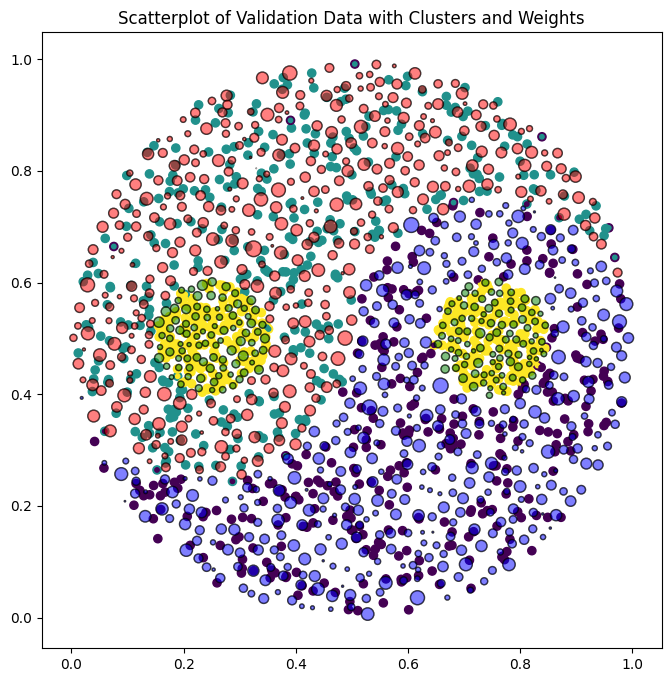

Performance: 0.98


In [26]:
validations_samples = np.load('data/validation_samples.npy')
validation_labels = np.load('data/validation_labels.npy')

# Scatterplot of the training data
plt.figure(figsize=(8,8))

# Draw the clusters

m_heat_mat2 = np.exp(-distance.cdist(validations_samples[:,:2], prototypes, 'sqeuclidean') / (2 * sigmas**2 + 1e-8))
m_heat_mat_aug2 = np.hstack((m_heat_mat2, np.ones((m_heat_mat2.shape[0], 1))))
output = np.einsum('ij,jk->ik', m_heat_mat_aug2, np.array(wts))
class_predict = np.argmax(output, axis=1)
print(f"Cls pred: {class_predict}")
plt.scatter(validations_samples[:,0], validations_samples[:,1], c=class_predict, cmap='viridis', s=35)
plt.scatter(validations_samples[:,0], validations_samples[:,1], c=validation_labels, cmap='viridis', s=10)


for i in range(num_hidden_nodes):
    circle = plt.Circle(prototypes[i], sigmas[i], alpha=0.5, facecolor='none', edgecolor='black')
    plt.gca().add_patch(circle)
    # plt.text(prototypes[i, 0], prototypes[i, 1], str(i), color='black')
    
    # Determine the class of the node
    if classes[i] == 0:
        facecolor = 'blue'
    elif classes[i] == 1:
        facecolor = 'red'
    else:
        facecolor = 'green'
        
    circle = plt.Circle(prototypes[i], sigmas[i], alpha=0.5, facecolor=facecolor, edgecolor='black')
    plt.gca().add_patch(circle)
    
plt.title('Scatterplot of Validation Data with Clusters and Weights')

plt.show()

print(f"Performance: {np.sum(class_predict == validation_labels) / validation_labels.shape[0]}")